<a href="https://colab.research.google.com/github/hinsley/colabs/blob/master/Coronavirus_Projections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### To Do

- [ ] Improve projections.
- [X] Change 68% confidence interval error bars to 95% or 99.7%.
- [X] Add US states projections for confirmed cases & deaths.
- [ ] Add Canadian provincial projections for confirmed cases & deaths.

### What can be done to improve projections?

- [ ] Do not factor zero values into dataset to fit curve to.
- [ ] Fit derivative curve instead of sigmoid curve.
- [ ] Try weighting newer values as more important.
- [ ] Use lognormal probability density function instead of sigmoid.

In [1]:
!pip install uncertainties

     |████████████████████████████████| 235kB 2.8MB/s 
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96457 sha256=b2dca055195bd86ec5eb0fa9804f89849fc89e318ddf786892652a5bdf626c29
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
Successfully built uncertainties


In [0]:
from uncertainties import ufloat
import numpy as np
import pandas as pd
from uncertainties import unumpy as unp
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from datetime import date, datetime, timedelta

In [0]:
def sigmoid(x, a, b, c):
  """
  Args:
  - x: Time input.
  - a: Horizontal translation (positive: right).
  - b: Vertical scalar.
  - c: Horizontal scalar.
  """

  result = b * (1-1/(1+np.exp(c * (x - a))))

  return result

def usigmoid(x, a, b, c):
  result = b * (1-1/(1+unp.exp(c * (x - a))))

  return result


# Finding projective maximum spread rate

$\sigma = b \left(1 - \frac{1}{1 + e^{c(x - a)}}\right)$

The maximum spread rate can be found by the spread rate $\sigma_x(x_\text{inflection})$ where
$\sigma_{xx}(x_\text{inflection}) = 0$.

$\sigma_x = -b \frac{\partial}{\partial x} \frac{1}{1+e^{c(x-a)}}$

$= b \frac{1}{(1+e^{c(x-a)})^2} \frac{\partial}{\partial x}(1+e^{c(x-a)})$

$= \frac{b}{(1+e^{c(x-a)})^2e^{ac}} \frac{\partial}{\partial x}(e^{cx})$

$= bc \frac{e^{c(x-a)}}{(1+e^{c(x-a)})^2}$

$= bc \frac{1 + e^{c(x-a)} - 1}{(1+e^{c(x-a)})^2}$

$= bc \left( \frac{1}{1 + e^{c(x-a)}} - \frac{1}{(1+e^{c(x-a)})^2} \right)$

$= bc \frac{1}{1+e^{c(x-a)}} \left( 1 - \frac{1}{1+e^{c(x-a)}} \right)$

$\sigma_x = \frac{c}{b} \sigma (b - \sigma)$

$\sigma_{xx} = \frac{c}{b} \frac{\partial}{\partial x}\left[\sigma(b-\sigma)\right]$

$= \frac{c}{b} \left[ \sigma_x (b - \sigma) - \sigma \sigma_{x} \right]$

$\sigma_{xx} = c (\sigma_x - \frac{2}{b}\sigma \sigma_x)$

From this derivation we can tell that the following equation must be true at the inflection point:

$\sigma_x = \frac{2}{b} \sigma \sigma_x$

$\sigma = \frac{b}{2}$

Returning to our definition of $\sigma$, we now have that:

$e^{c(x-a)} = 1$

and thus $x = a$, indicating that the maximum spread rate will be $\sigma_x(a)$.


In [0]:
def sigmoid_derivative(x, a, b, c):
  sigma = sigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def usigmoid_derivative(x, a, b, c):
  sigma = usigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def sigmoidal_max_daily_growth_rate(a, b, c):
  return usigmoid_derivative(a, a, b, c)

In [0]:
def log_growth_rate_domain(growth_rate_curve, *args):
  return unp.log(growth_rate_curve(*args))

In [0]:
def fit_growth(curve_function, xs, ys):
  """
  Args:
  - curve_function: A 3-parameter function of x that produces a growth rate at a
    particular time. The first parameter should be a vertical scalar (usually
    equal to supremum of cumulative time series). The second parameter should be
    a horizontal shift. The third parameter should control onset rate in some
    fashion.
  - xs: Times of data points in time series to fit curve to.
  - ys: Magnitudes of data points in time series to fit curve to.
  Returns:
  - If convergent, returns a list of ufloats containing nominal parameters for
    `curve_function` with standard deviations calculated from the fit's
    covariance matrix diagonal.
  - If divergent, returns None.
  """

  initial_guesses = [max(ys)/2, 0, 0]
  while True:
    try:
      popt, pcov = curve_fit(curve_function, xs, ys, p0=initial_guesses, maxfev=500*(len(xs)+1))
      break
    except RuntimeError:
      initial_guesses[0] = (initial_guesses[0] + 1) * 1.5
  
  convergent = all([param > 0 for
                    param in
                    popt]) and all([invcov != 0 for
                                    invcov in
                                    1/pcov.flatten()])
  
  if convergent:
    return [ufloat(*val_pair) for val_pair in zip(popt, np.sqrt(np.diag(pcov)))]

In [7]:
ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/who_covid_19_situation_reports/who_covid_19_sit_rep_time_series/who_covid_19_sit_rep_time_series.csv")

ts_df

Province/States    Country/Region  ...  4/2/2020  4/3/2020
0         Confirmed          Globally  ...  896450.0  972303.0
1            Deaths          Globally  ...   45525.0   50321.0
2         Confirmed             China  ...   82724.0   82802.0
3         Confirmed  Outside of China  ...  813726.0  889501.0
4            Deaths             China  ...    3327.0    3331.0
..              ...               ...  ...       ...       ...
254          Deaths               NaN  ...    3279.0    3438.0
255       Confirmed               NaN  ...  216912.0  247473.0
256          Deaths               NaN  ...    4565.0    5600.0
257       Confirmed               NaN  ...    4702.0    5263.0
258          Deaths               NaN  ...     127.0     164.0

[259 rows x 77 columns]

# Confirmed Cases

## By Country

### Aggregated

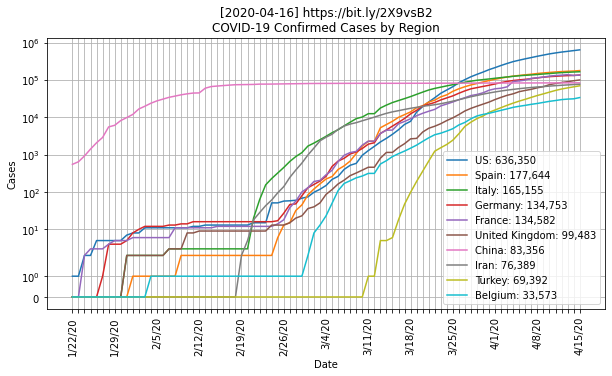

In [8]:
ts_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

ts_only_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_confirmed_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_confirmed_df.index[:legend_size]:
  ax.plot(ts_only_confirmed_df.loc[region], label=f"{region}: {ts_only_confirmed_df.loc[region][-1]:,}")

ax.legend()
plt.yscale("symlog")
plt.ylabel("Cases")
plt.xlabel("Date")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

### Projections

In [9]:
ts_global_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).sum()[1:]

ts_global_confirmed_df

1/22/20        555
1/23/20        654
1/24/20        941
1/25/20       1434
1/26/20       2118
            ...   
4/11/20    1771514
4/12/20    1846679
4/13/20    1917319
4/14/20    1976191
4/15/20    2056054
Length: 85, dtype: object

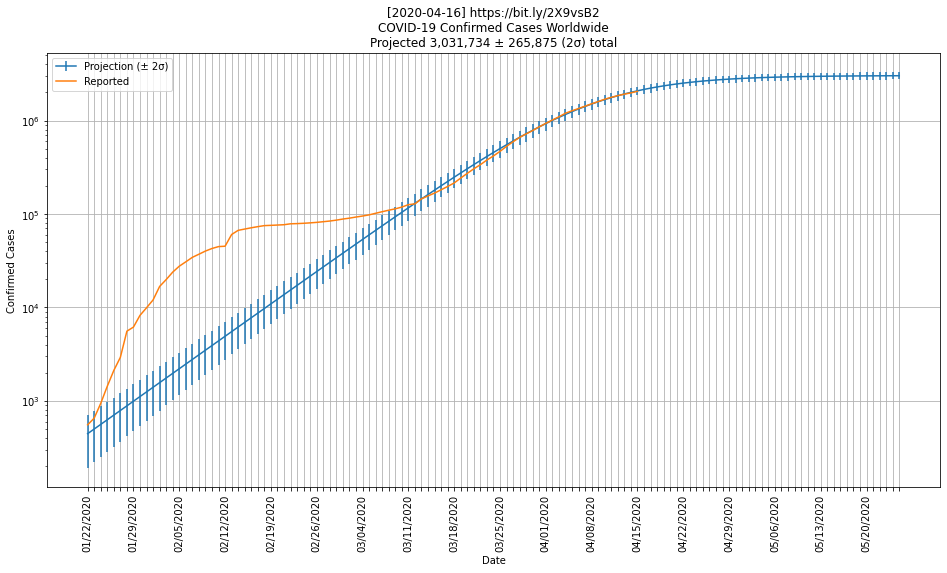

In [10]:
u_popt = fit_growth(sigmoid, *zip(*enumerate(ts_global_confirmed_df)))

if u_popt is not None:
  curve = lambda x: usigmoid(x, *u_popt)

# Prediction.
fig, ax = plt.subplots(1, figsize=(16, 8))

days_to_plot = 125

if u_popt is not None:
  u_ys = [curve(x) for x in range(days_to_plot)]
  ax.errorbar(x=range(len(u_ys)), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (± 2σ)")
ax.errorbar(x=range(ts_global_confirmed_df.size), y=ts_global_confirmed_df, label="Reported")

ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases Worldwide\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")

day_zero = datetime(2020, 1, 22, 0, 0)

ax.set_xticks(range(days_to_plot))
ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

plt.setp(ax.get_xmajorticklabels(), rotation=90)

i = 0
for label in ax.get_xmajorticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

ax.grid()
ax.legend()
ax.set_yscale("log")

ax.set_xlabel("Date")
ax.set_ylabel("Confirmed Cases")

plt.show()

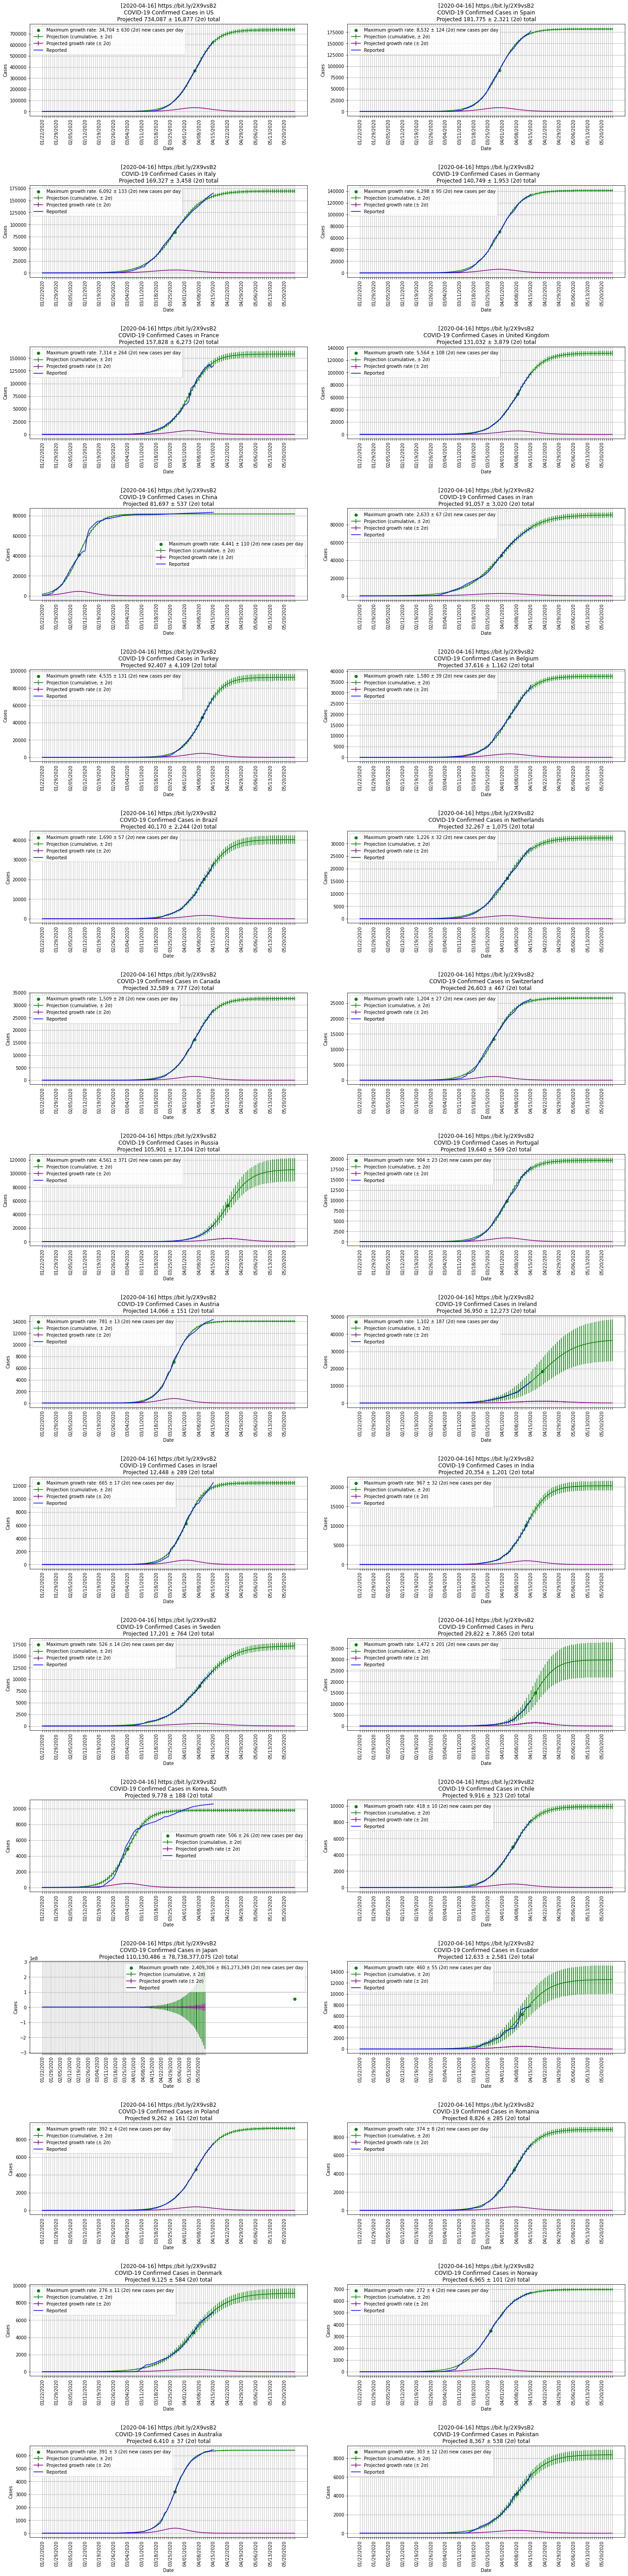

In [11]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_confirmed_df[:min(plot_top_n_countries, len(ts_only_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev):,} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By United States state / territory

In [12]:
ts_us_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

ts_us_confirmed_df = ts_us_confirmed_df.drop(["UID", "iso2", "iso3", "code3",
                                              "FIPS", "Admin2",
                                              "Country_Region", "Lat", "Long_",
                                              "Combined_Key"], axis=1).groupby("Province_State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

ts_us_confirmed_df

1/22/20  1/23/20  1/24/20  ...  4/13/20  4/14/20  4/15/20
Province_State                                       ...                           
New York                        0        0        0  ...   195749   203020   214454
New Jersey                      0        0        0  ...    64584    68824    71030
Massachusetts                   0        0        0  ...    26867    28164    29918
Michigan                        0        0        0  ...    25635    27001    28059
Pennsylvania                    0        0        0  ...    24292    25465    26753
California                      0        0        0  ...    23931    25356    26686
Illinois                        0        0        1  ...    22025    23248    24593
Florida                         0        0        0  ...    21019    21628    22511
Louisiana                       0        0        0  ...    21016    21518    21951
Texas                           0        0        0  ...    14275    15006    15907
Georgia                         0        0        0  ...    13315    14578    14987
Connecticut                     0        0        0  ...    13381    13989    14755
Washington                      1        1        1  ...    10635    10799    10942
Maryland                        0        0        0  ...     8936     9472    10032
Indiana                         0        0        0  ...     8359     8527     8960
Colorado                        0        0        0  ...     7691     7950     7956
Ohio                            0        0        0  ...     6975     7285     7794
Virginia                        0        0        0  ...     5747     6182     6500
Tennessee                       0        0        0  ...     5610     5827     5827
North Carolina                  0        0        0  ...     4886     5113     5340
Missouri                        0        0        0  ...     4515     4746     4791
Alabama                         0        0        0  ...     3734     3953     4075
Arizona                         0        0        0  ...     3705     3809     3964
Wisconsin                       0        0        0  ...     3428     3555     3721
South Carolina                  0        0        0  ...     3391     3553     3656
Mississippi                     0        0        0  ...     2942     3087     3360
Rhode Island                    0        0        0  ...     2665     3251     3251
Nevada                          0        0        0  ...     2990     3134     3211
Utah                            0        0        0  ...     2363     2417     2548
Oklahoma                        0        0        0  ...     2069     2184     2263
Kentucky                        0        0        0  ...     2018     2048     2210
District of Columbia            0        0        0  ...     1955     2058     2197
Delaware                        0        0        0  ...     1758     1926     2014
Iowa                            0        0        0  ...     1710     1899     1995
Minnesota                       0        0        0  ...     1621     1695     1809
Oregon                          0        0        0  ...     1584     1633     1663
Arkansas                        0        0        0  ...     1410     1498     1569
Kansas                          0        0        0  ...     1390     1441     1504
New Mexico                      0        0        0  ...     1262     1345     1484
Idaho                           0        0        0  ...     1426     1464     1473
South Dakota                    0        0        0  ...      868      988     1168
New Hampshire                   0        0        0  ...      985      922     1139
Puerto Rico                     0        0        0  ...      903      923      974
Nebraska                        0        0        0  ...      814      897      901
Maine                           0        0        0  ...      698      735      770
Vermont                         0        0        0  ...      748      752    

### Projections

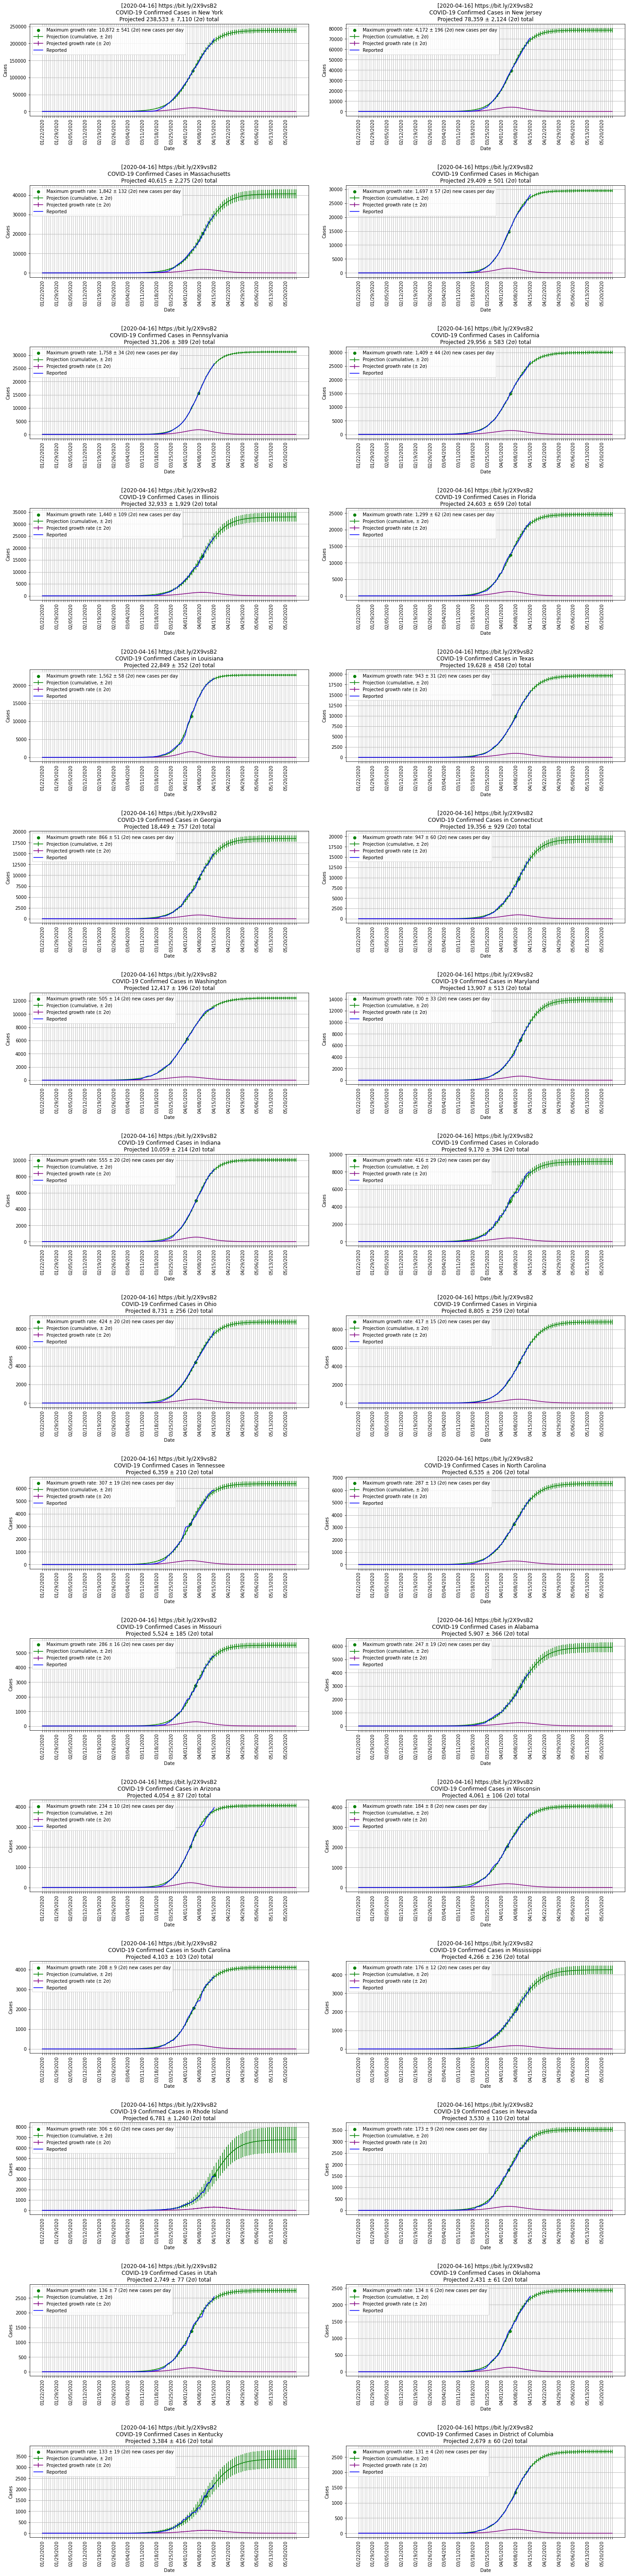

In [13]:
plot_top_n_states = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_confirmed_df[:min(plot_top_n_states, len(ts_us_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev * 2):,} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

# Deaths

## By Country

### Aggregated

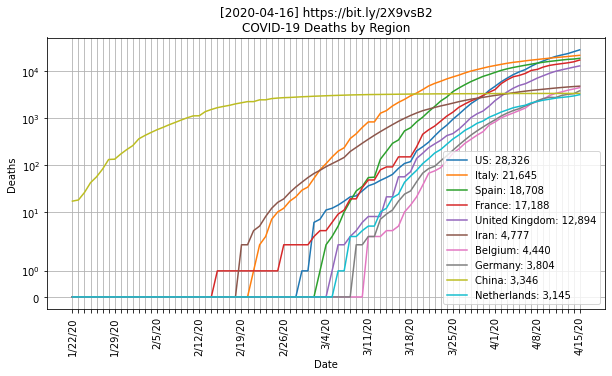

In [14]:
ts_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

ts_only_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_deaths_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_deaths_df.index[:legend_size]:
  ax.plot(ts_only_deaths_df.loc[region], label=f"{region}: {ts_only_deaths_df.loc[region][-1]:,}")

ax.legend()
plt.yscale("symlog")
plt.ylabel("Deaths")
plt.xlabel("Date")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

### Projections

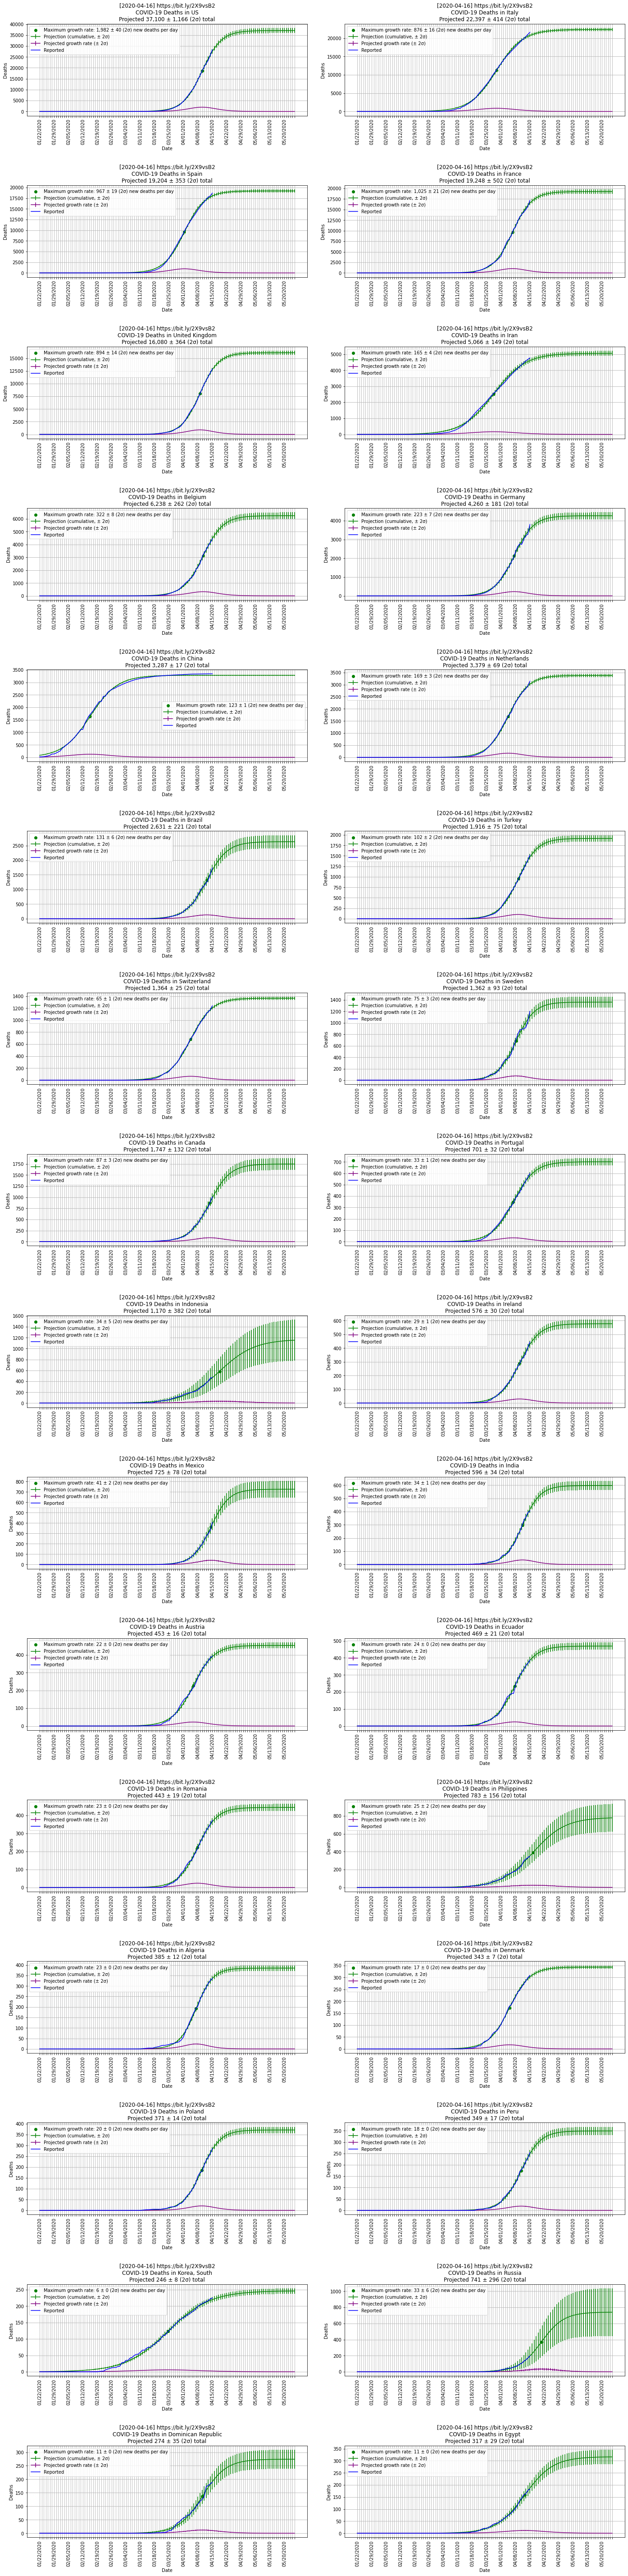

In [15]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_deaths_df[:min(plot_top_n_countries, len(ts_only_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)
  
  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev):,} (2σ) new deaths per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By United States state / territory

In [16]:
ts_us_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

ts_us_deaths_df = ts_us_deaths_df.drop(["UID", "iso2", "iso3", "code3",
                                           "FIPS", "Admin2",
                                           "Country_Region", "Lat", "Long_",
                                           "Combined_Key", "Population"], axis=1).groupby("Province_State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

ts_us_deaths_df

1/22/20  1/23/20  1/24/20  ...  4/13/20  4/14/20  4/15/20
Province_State                                       ...                           
New York                        0        0        0  ...    10058  10842.0    11617
New Jersey                      0        0        0  ...     2443   2805.0     3156
Michigan                        0        0        0  ...     1602   1768.0     1921
Massachusetts                   0        0        0  ...      844    844.0     1108
Louisiana                       0        0        0  ...      884   1013.0     1103
Illinois                        0        0        0  ...      798    868.0      949
Connecticut                     0        0        0  ...      602    671.0      868
California                      0        0        0  ...      715    768.0      861
Pennsylvania                    0        0        0  ...      589    691.0      779
Florida                         0        0        0  ...      499    571.0      596
Georgia                         0        0        0  ...      465    525.0      552
Washington                      0        0        0  ...      513    530.0      552
Indiana                         0        0        0  ...      350    387.0      436
Texas                           0        0        0  ...      305    342.0      375
Ohio                            0        0        0  ...      274    324.0      362
Colorado                        0        0        0  ...      306    327.0      328
Maryland                        0        0        0  ...      262    302.0      311
Virginia                        0        0        0  ...      149    154.0      195
Wisconsin                       0        0        0  ...      154    170.0      183
Missouri                        0        0        0  ...      123    149.0      153
Arizona                         0        0        0  ...      122    131.0      142
Nevada                          0        0        0  ...      114    126.0      131
North Carolina                  0        0        0  ...       94    112.0      130
Tennessee                       0        0        0  ...      109    124.0      124
Oklahoma                        0        0        0  ...       99    108.0      123
Mississippi                     0        0        0  ...       98    111.0      122
Alabama                         0        0        0  ...       99    114.0      118
Kentucky                        0        0        0  ...      113    106.0      115
South Carolina                  0        0        0  ...       82     97.0      106
Minnesota                       0        0        0  ...       70     79.0       87
Rhode Island                    0        0        0  ...       63     80.0       80
District of Columbia            0        0        0  ...       52     67.0       72
Kansas                          0        0        0  ...       62     69.0       71
Oregon                          0        0        0  ...       53     55.0       58
Iowa                            0        0        0  ...       41     49.0       53
Puerto Rico                     0        0        0  ...       45     45.0       51
Delaware                        0        0        0  ...       41     43.0       46
Idaho                           0        0        0  ...       27     33.0       39
New Mexico                      0        0        0  ...       26     31.0       36
Arkansas                        0        0        0  ...       29     32.0       33
New Hampshire                   0        0        0  ...       23     25.0       32
Vermont                         0        0        0  ...       28     29.0       29
Maine                           0        0        0  ...       19     20.0       24
Utah                            0        0        0  ...       13     18.0       20
Nebraska                        0        0        0  ...       17     20.0       20
West Virginia                   0        0        0  ...        8      9.0    

### Projections

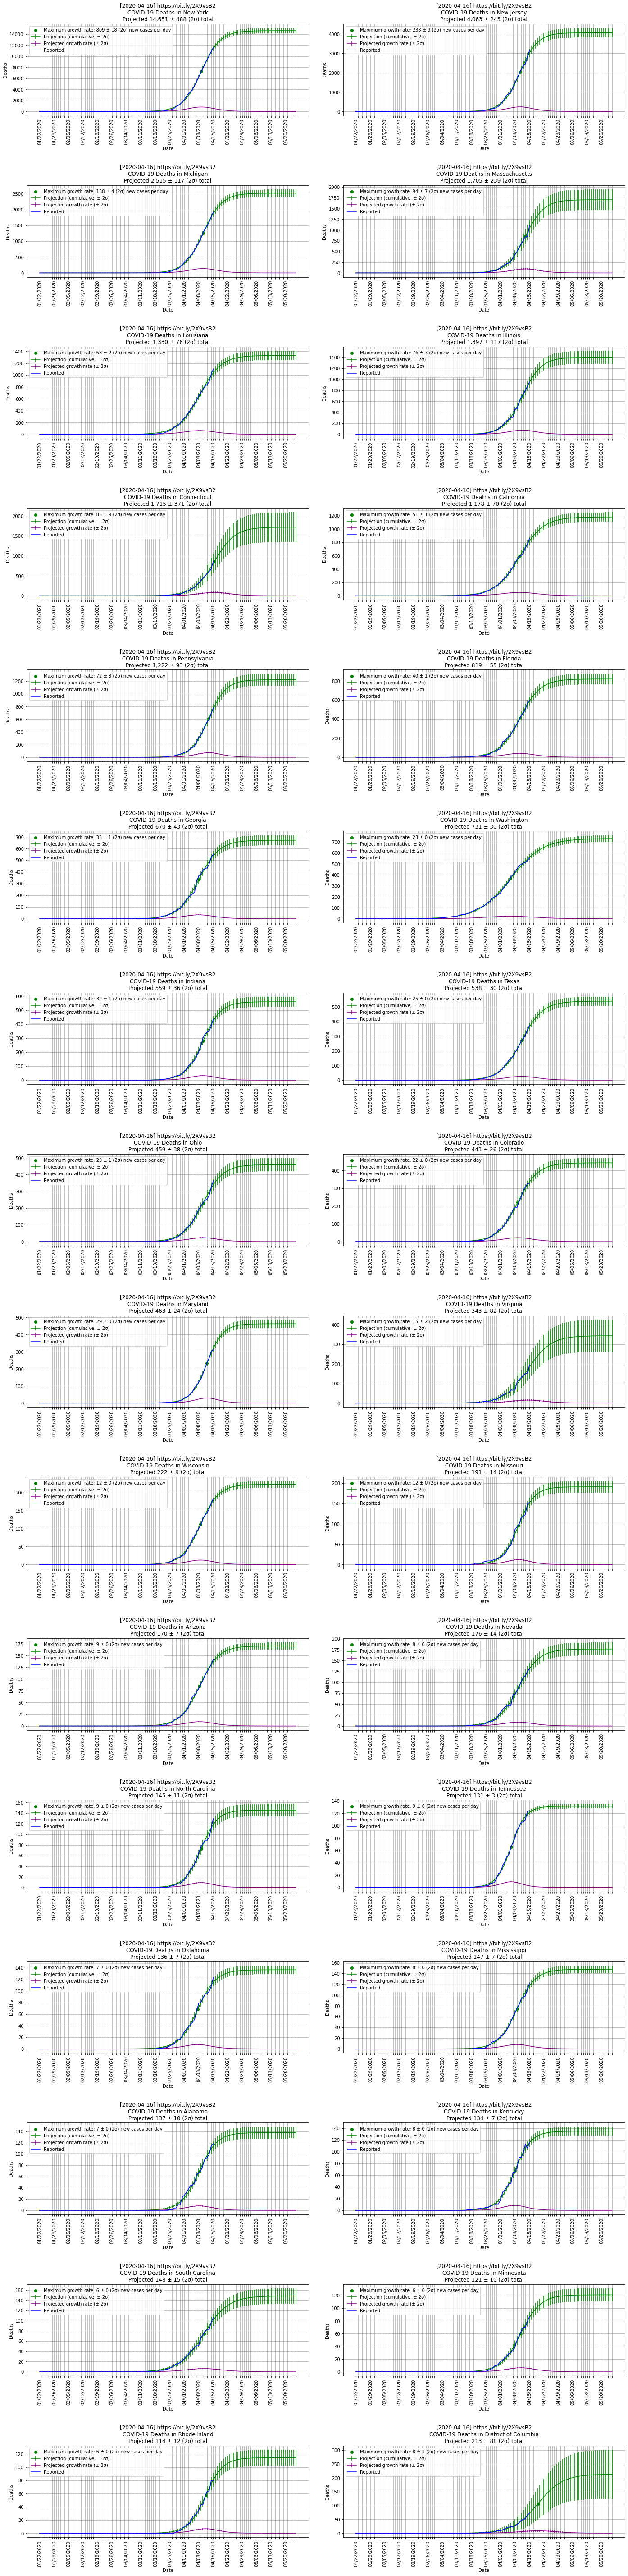

In [17]:
plot_top_n_states = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_deaths_df[:min(plot_top_n_states, len(ts_us_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev):,} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By Country

### Aggregated

In [18]:
ts_only_consol_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).sum()[1:]

ts_only_consol_deaths_df

1/22/20        17
1/23/20        18
1/24/20        26
1/25/20        42
1/26/20        56
            ...  
4/11/20    108503
4/12/20    114091
4/13/20    119482
4/14/20    125984
4/15/20    134177
Length: 85, dtype: object

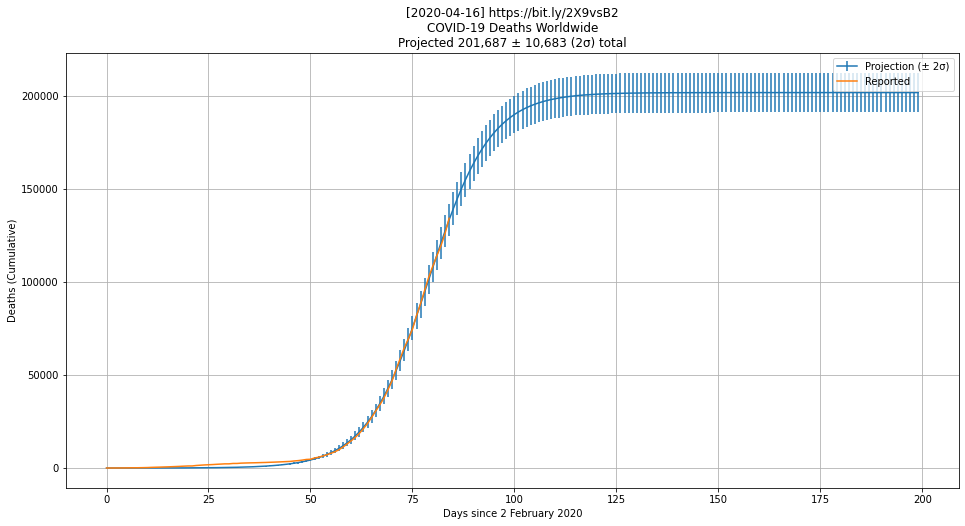

In [19]:
u_popt = fit_growth(sigmoid, *zip(*enumerate(ts_only_consol_deaths_df)))

if u_popt is not None:
  curve = lambda x: usigmoid(x, *u_popt)

# Prediction.
plt.figure(figsize=(16, 8))
if u_popt is not None:
  u_ys = [curve(x) for x in range(200)]
  plt.errorbar(x=range(len(u_ys)), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (± 2σ)")
plt.errorbar(x=range(ts_only_consol_deaths_df.size), y=ts_only_consol_deaths_df, label="Reported")

plt.title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths Worldwide\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
plt.grid()
plt.xlabel("Days since 2 February 2020")
plt.ylabel("Deaths (Cumulative)")
#plt.yscale("symlog")
plt.legend()

plt.show()